# The AR6 Shared Socioeconomic Pathway Effective Radiative Forcing Timeseries, 1750-2500

In [1]:
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats
import random
import pandas as pd
from tqdm import tqdm_notebook
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *

import matplotlib.pyplot as pl
import json

In [2]:
forcing = {}

check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)

check_and_download(
    '../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-gidden','ssp370-lowNTCF-aerchemmip','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm_notebook(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:118: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


(250.0, 280.0)

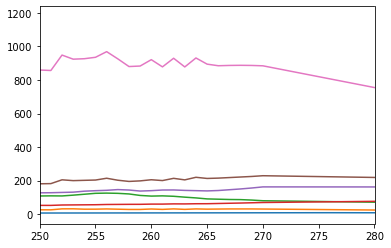

In [5]:
pl.plot(new_emissions['ssp585'])
pl.xlim(250,280)

## Solar radiation
ERF = TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor

We rebase to the two solar cycles 1745-1765 as our estimate of "pre-industrial". This follows AR5 and is a period of somewhat lower solar activity than 1850-1873 used for CMIP6 pre-industrial.

In [6]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_erf = np.zeros((751))
solar_erf[:550] = df.solar_erf.loc[1750:2299].values
for scenario in scenarios:
    forcing[scenario]['solar']=solar_erf

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900) and CMIP6 (1850-2014). **DIFFERENCE TO AR6 TIMESERIES** we ramp down to zero over 10 years from 2014, which differs from AR6 where we use Glossac

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis)

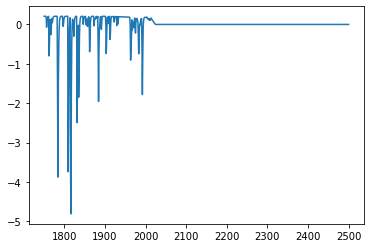

In [7]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_erf = np.zeros((751))
volcanic_erf[:265] = df.volcanic_erf.loc[1750:2014].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_erf[264:275] = volcanic_erf[264] * np.linspace(1,0,11)
volcanic_erf[275:] = 0.
pl.plot(np.arange(1750,2501), volcanic_erf[:])
#emissions = np.loadtxt('../data/SSP460_INTERIM_EMISSIONS.csv', skiprows=3, delimiter=',')

for scenario in scenarios:
    forcing[scenario]['volcanic']=volcanic_erf

## Aerosol forcing
Use a combination of the model-derived time series from Smith et al. (2020; JGRA; submitted) and the analysis of MERRA2 and CAMS reanalysis from Bellouin et al. (2020; ESSD).

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

- 1750 - 1979: Smith et al. only
- 1980 - 2002: mean of Smith et al. and MERRA2
- 2003 - 2014: weighted mean of Smith et al. (0.5), MERRA2 (0.25) and CAMS (0.25)

- **TODO: update this with Nicolas' actual figures rather than my graph-derived ones**
- **TODO: put Smith et al 2020 code on the repository and generate coefficients**

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [8]:
def aerocom_n(x, bc, oc, so2, nh3):
    return bc*x[0] + oc*x[1] + so2*x[2] + nh3*x[3]

def shindell(x, beta, n0, n1, n2):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1 + x[2]/n2)

df = pd.read_csv('../data_input_large/ERFari_samples.csv')
ari_coeffs = df.values

df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples = 25000
NINETY_TO_ONESIGMA = scipy.stats.norm.ppf(0.95)

In [9]:
# SCALE TO ASSESSMENT
ERFari_scale = scipy.stats.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples)
ERFaci_scale = scipy.stats.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=samples)

array([-2.01509314, -1.73275374, -1.30257349, -0.87342951, -0.58912789])

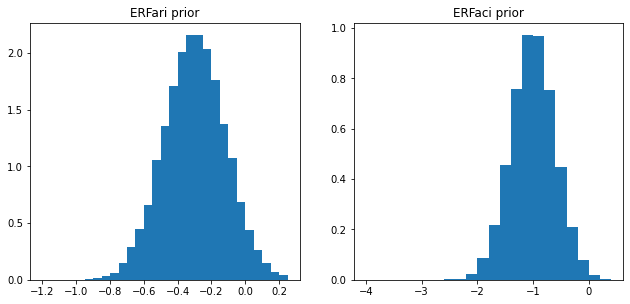

In [10]:
fig,ax = pl.subplots(1,2, figsize=(27/2.54,12/2.54))
ax[0].hist(ERFari_scale, bins=np.arange(-1.2,0.3,0.05), density=True);
ax[0].set_title('ERFari prior');
ax[1].hist(ERFaci_scale, bins=np.arange(-4,0.5,0.2), density=True);
ax[1].set_title('ERFaci prior');
np.percentile(ERFari_scale+ERFaci_scale, (5,16,50,84,95))

**TODO: argh**

In [11]:
ERFari = {}
ERFaci = {}

bc_20101750 = scipy.stats.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = scipy.stats.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = scipy.stats.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nit_20101750 = scipy.stats.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nox = 0.4*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NOx'])-emissions_ceds_update.loc[1750,'NOx'])
beta_nh3 = 0.6*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

for scenario in tqdm_notebook(scenarios):
    ERFari[scenario] = np.zeros((751,samples))
    ERFaci[scenario] = np.zeros((751,samples))
    
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    nox = new_emissions[scenario]['NOx'].values.squeeze()
    
    for i in tqdm_notebook(range(samples), leave=False):
        ERFari[scenario][:, i] = (
            (so2-so2[0]) * beta_so2[i] +
            (bc-bc[0]) * beta_bc[i] +
            (oc-oc[0]) * beta_oc[i] +
            (nh3-nh3[0]) * beta_nh3[i] +
            (nox-nox[0]) * beta_nox[i]
        )
    
    for i in tqdm_notebook(range(samples), leave=False):

        ts2010 = np.mean(
            shindell(
                [
                    so2[255:265],
                        bc[255:265]+
                        oc[255:265],
                    nh3[255:265]
                ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
            )
        )
        ts1750 = shindell(
            [
                so2[0],
                    bc[0]+
                    oc[0],
                nh3[0]
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
        ERFaci[scenario][:,i] = (
            shindell([so2, bc+oc, nh3], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2])
        - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
ERFari_median = {}
ERFaci_median = {}

for scenario in tqdm_notebook(scenarios):
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    nox = new_emissions[scenario]['NOx'].values.squeeze()
    
    beta_bc = 0.3/(np.mean(bc[255:265])-bc[0])
    beta_oc = -0.09/(np.mean(oc[255:265])-oc[0])
    beta_so2 = -0.4/(np.mean(so2[255:265])-so2[0])
    beta_nox = 0.4*(-0.11)/(np.mean(nox[255:265])-nox[0])
    beta_nh3 = 0.6*(-0.11)/(np.mean(nh3[255:265])-nh3[0])
    ERFaci_median[scenario] = np.percentile(ERFaci[scenario], 50, axis=1) * (-1.0)/(np.percentile(ERFaci[scenario], 50, axis=1)[255:265].mean())
    ERFari_median[scenario] = (
        (so2-so2[0]) * beta_so2 +
        (bc-bc[0]) * beta_bc +
        (oc-oc[0]) * beta_oc +
        (nh3-nh3[0]) * beta_nh3 +
        (nox-nox[0]) * beta_nox
    )

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [13]:
#results = load_dict_from_hdf5('../data_input_large/twolayer_with_CEDS-UPDATE.h5')
#weight = results['CEDS-UPDATE']['ensemble_weight']

In [14]:
# scale up to the assessment
# not required now
# ERFari_unscaled = np.sum(ERFari[scenario]*weight, axis=1)
# ERFaci_unscaled = np.sum(ERFaci[scenario]*weight, axis=1)
# rebase_ari = -0.3/np.mean(ERFari_unscaled[255:265])
# rebase_aci = -1.0/np.mean(ERFaci_unscaled[255:265])
# for scenario in scenarios:
#     ERFari[scenario] = ERFari[scenario] * rebase_ari
#    ERFaci[scenario] = ERFaci[scenario] * rebase_aci

In [15]:
for scenario in tqdm_notebook(scenarios):   
    forcing[scenario]['aerosol-radiation_interactions'] = ERFari_median[scenario]
    forcing[scenario]['aerosol-cloud_interactions'] = ERFaci_median[scenario]
#    forcing[scenario]['aerosol-radiation_interactions'] = np.sum(ERFari[scenario]*weight, axis=1)
#    forcing[scenario]['aerosol-radiation_interactions'][230:253] = np.mean((np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[230:253], merra_ari[:23]), axis=0)
#    forcing[scenario]['aerosol-radiation_interactions'][253:265] = np.mean((np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[253:265], np.mean((merra_ari[23:35], cams_ari[:12]), axis=0)), axis=0)
#    forcing[scenario]['aerosol-cloud_interactions'] = np.sum(ERFaci[scenario]*weight, axis=1)
#    forcing[scenario]['aerosol-cloud_interactions'][230:253] = np.mean((np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[230:253], merra_aci[:23]), axis=0)
#    forcing[scenario]['aerosol-cloud_interactions'][253:265] = np.mean((np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[253:265], np.mean((merra_aci[23:35], cams_aci[:12]), axis=0)), axis=0)


/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


## BC on snow

Linear with emissions, 2019 = 0.08 in the historical from AR6

In [16]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.

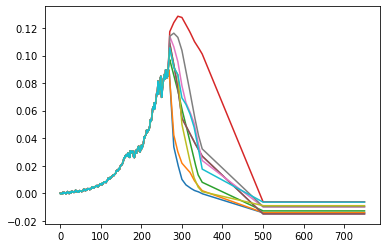

In [17]:
#bc2019 = new_emissions['ssp245']['BC'].values.squeeze()[269]
for scenario in scenarios:
    bc = new_emissions[scenario]['BC'].values.squeeze()
    forcing[scenario]['bc_on_snow'] = (bc-bc[0])/(bc_hist[269]-bc_hist[0])*0.08
    pl.plot(forcing[scenario]['bc_on_snow'])

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

**TODO update chapter for 2019 forcing**

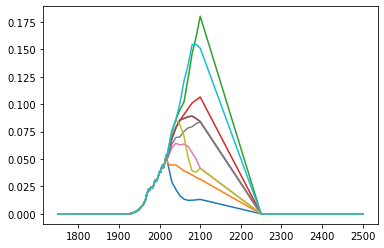

In [18]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
for scenario in scenarios:
    avi_nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    avi_nox[:265] = avi_nox_hist[:265]
    avi_nox[265:270] = np.linspace(1,0.2,5) * avi_nox_hist[265:270] + np.linspace(0,0.8,5) * avi_nox[265:270]
    contrail_forcing_2018 = 0.0574
    forcing[scenario]['contrails'] = avi_nox/avi_nox_hist[268] * contrail_forcing_2018
    pl.plot(np.arange(1750,2501), forcing[scenario]['contrails'])

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

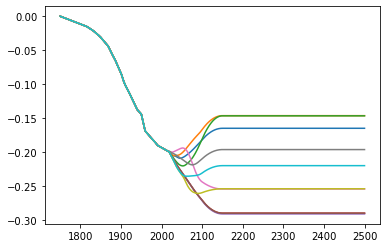

In [19]:
ghimire = pd.read_csv('../data_input/ghimire_curve_fit.csv')
for scenario in scenarios:
    lusf2019 = -0.20/np.cumsum(emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze())[269]  # include irrigation of -0.05 in Sherwood et al
    forcing[scenario]['land_use'] = np.cumsum(emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze())*lusf2019
    f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
    lusf2019 = -0.20/(f(2019)-f(1750))
    forcing[scenario]['land_use'][:269] = lusf2019*(f(np.arange(1750,2019))-f(1750))
    pl.plot(np.arange(1750, 2501), forcing[scenario]['land_use'])

## Greenhouse gas concentrations

For consistency I will use the observations for GHGs to 2019, and then ramp to SSPs in 2029.

**TODO** what are we doing about +5% in non-CO2 gases?

**TODO** use Meinshausen forcing relationship?

In [20]:
ghg_obs = pd.read_excel('../data_input/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
gases_obs = ghg_obs.columns.to_list()
gases_obs.remove('YYYY')
print(*(gases_obs))

gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

CO2 CH4 N2O HFC-134a HFC-23 HFC-32 HFC-125 HFC-143a HFC-152a HFC-227ea HFC-236fa HFC-245fa HFC-365mfc HFC-43-10mee NF3 SF6 SO2F2 CF4 C2F6 C3F8 c-C4F8 CFC-12 CFC-11 CFC-113 CFC-114 CFC-115 CFC-13 HCFC-22 HCFC-141b HCFC-142b CH3CCl3 CCl4 CH3Cl CH3Br CH2Cl2 CHCl3 Halon-1211 Halon-1301 Halon-2402 n-C4F10 n-C5F12 n-C6F14 i-C6F14 C7F16 C8F18 CFC-112 CFC-112a CFC-113a CFC-114a HCFC-133a HCFC-31 HCFC-124


/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


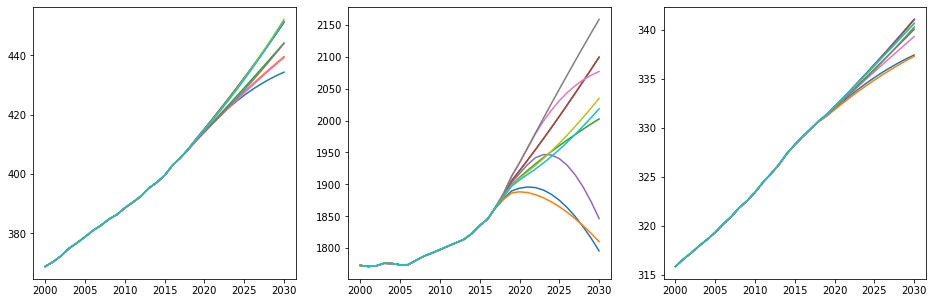

In [21]:
fig, ax = pl.subplots(1,3,figsize=(16,5))
for scenario in tqdm_notebook(scenarios):
    forcing[scenario]['co2'] = np.zeros(751)
    forcing[scenario]['ch4'] = np.zeros(751)
    forcing[scenario]['n2o'] = np.zeros(751)

    co2 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CO2')),'1750':'2500'].values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    co2[:265] = ghg_obs['CO2'].values[:265]
    ch4[:265] = ghg_obs['CH4'].values[:265]
    n2o[:265] = ghg_obs['N2O'].values[:265]
    
    co2[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CO2'].values[264:270] + np.linspace(0,1,6) * co2[264:270]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    
    for i, year in enumerate(range(1750,2501)):
        forcing[scenario]['co2'][i], forcing[scenario]['ch4'][i], forcing[scenario]['n2o'][i] = meinshausen( #etminan(
            [co2[i], ch4[i], n2o[i]], 
            [co2[0], ch4[0], n2o[0]], scale_F2x=False)

    # include rapid adjustments for CO2 and CH4 (FOD numbers):
    forcing[scenario]['co2'] = 1.05 * forcing[scenario]['co2']
    forcing[scenario]['ch4'] = 0.86 * forcing[scenario]['ch4']
    
    ax[0].plot(np.arange(2000,2031), co2[250:281])
    ax[1].plot(np.arange(2000,2031),ch4[250:281])
    ax[2].plot(np.arange(2000,2031),n2o[250:281])

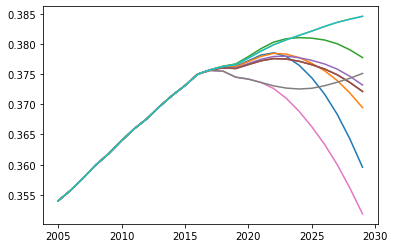

In [22]:
gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888, # not given in Hodnebrog: assume same as n-form
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf
    'CFC-112a':     0.24564,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf - assume same as 112
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094,  # Etminan et al., 2014
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747, # assume same as 114 - does this make sense?
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

meins_names={
    'HFC-125':      'HFC125',
    'HFC-134a':     'HFC134a',
    'HFC-143a':     'HFC143a',
    'HFC-152a':     'HFC152a',
    'HFC-227ea':    'HFC227ea',
    'HFC-23':       'HFC23',
    'HFC-236fa':    'HFC236fa',
    'HFC-245fa':    'HFC245fa',
    'HFC-32':       'HFC32',
    'HFC-365mfc':   'HFC365mfc',
    'HFC-43-10mee': 'HFC4310mee',
    'NF3':          'NF3',
    'C2F6':         'C2F6',
    'C3F8':         'C3F8',
    'n-C4F10':      'C4F10',
    'n-C5F12':      'C5F12',
    'n-C6F14':      'C6F14',
    'i-C6F14':      None,
    'C7F16':        'C7F16',
    'C8F18':        'C8F18',
    'CF4':          'CF4',
    'c-C4F8':       'cC4F8',
    'SF6':          'SF6',
    'SO2F2':        'SO2F2',
    'CCl4':         'CCl4',
    'CFC-11':       'CFC11',
    'CFC-112':      'CFC112',  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf
    'CFC-112a':     None,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf - assume same as 112
    'CFC-113':      'CFC113',
    'CFC-113a':     None,  # Etminan et al., 2014
    'CFC-114':      'CFC114',
    'CFC-114a':     None, # assume same as 114 - does this make sense?
    'CFC-115':      'CFC115',
    'CFC-12':       'CFC12',
    'CFC-13':       None,
    'CH2Cl2':       'CH2Cl2',
    'CH3Br':        'CH3Br',
    'CH3CCl3':      'CH3CCl3',
    'CH3Cl':        'CH3Cl',
    'CHCl3':        'CHCl3',
    'HCFC-124':     None,
    'HCFC-133a':    None,
    'HCFC-141b':    'HCFC141b',
    'HCFC-142b':    'HCFC142b',
    'HCFC-22':      'HCFC22',
    'HCFC-31':      None,
    'Halon-1211':   'Halon1211',
    'Halon-1301':   'Halon1301',
    'Halon-2402':   'Halon2402',
}

for scenario in scenarios:
    forcing[scenario]['other_wmghg'] = np.zeros(751)
    for gas in gases_obs[3:]:
        #print(concentrations.loc[(concentrations['Scenario']=='ssp245')&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(gas)),'1750':'2500'].values.squeeze())
        #for i,year in enumerate(range(1750,2501)):
        #    print(concentrations.loc[(concentrations['Scenario']=='ssp245')&(concentrations['Region']=='World')&(concentrations['Variable']=='Atmospheric Concentrations|%s' % gas),'%s' % year])
        meins = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(meins_names[gas])),'1750':'2500'].values.squeeze()
        if meins.shape == (0,751):
            meins = np.zeros(751)
        obs = ghg_obs[gas].values[:270]
        conc = np.zeros(751)
        conc[:265] = obs[:265]
        conc[264:270] = np.linspace(1.0,0.0,6) * obs[264:270] + np.linspace(0,1,6) * meins[264:270]
        conc[270:] = meins[270:]
        forcing[scenario]['other_wmghg'] = forcing[scenario]['other_wmghg'] + ((conc - conc[0]) * radeff[gas] * 0.001)
    pl.plot(np.arange(2005,2030), forcing[scenario]['other_wmghg'][255:280])

## Tropospheric ozone

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. **TODO** coefficients from AerChemMIP

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


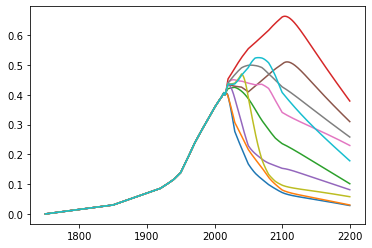

In [23]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data_input/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_trop.insert(0, 1750, -0.03)
skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
skeie_trop = skeie_trop + 0.03
f = interp1d(skeie_trop.columns, skeie_trop.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
o3tr = f(years)

for scenario in tqdm_notebook(scenarios):
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    ch4[:265] = ghg_obs['CH4'].values[:265]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    co = new_emissions[scenario]['CO']
    nox = new_emissions[scenario]['NOx']
    voc = new_emissions[scenario]['VOC']

    delta_Eco = co[255:265].mean() - co[100:109].mean()
    delta_Enox = nox[255:265].mean() - nox[100:109].mean()
    delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
    delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

    # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
    radeff_ch4 = 0.166/delta_Cch4
    radeff_co  = 0.055/delta_Eco
    radeff_nox = 0.119/delta_Enox
    radeff_voc = 0.035/delta_Evoc

    fac_cmip6_skeie = (
        (
        radeff_ch4 * delta_Cch4 +
        radeff_co  * delta_Eco +
        radeff_nox * delta_Enox +
        radeff_voc * delta_Evoc
        ) / (o3tr[260]-o3tr[100])
    )
    ts = np.vstack((ch4, co, nox, voc)).T

    def fit_stevenson(x, rch4, rco, rnox, rvoc):
        return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

    p, cov = curve_fit(
        fit_stevenson, 
        ts[100:261,:].T - ts[100:261, :].T,
        o3tr[100:261],
        bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
                (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
    )

    forcing[scenario]['o3_tropospheric'] = np.zeros((751))
    forcing[scenario]['o3_tropospheric'][:265] = o3tr[:265]
    forcing[scenario]['o3_tropospheric'][265:] = (
        p[0] * (ch4[265:] - ch4[0]) +
        p[1] * (co[265:]  - co[0]) +
        p[2] * (nox[265:]  - nox[0])+
        p[3] * (voc[265:]  - voc[0])
    )# + o3tr[264]

    pl.plot(np.arange(1750,2201), forcing[scenario]['o3_tropospheric'][:451])

## Stratospheric ozone

I ain't got no clud what to do here.

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. **TODO** coefficients from AerChemMIP **for the positive component**

In the Skeie models, it looks like negative forcing from ODSs has recovered to zero - so assume no future dependence on EESC.

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


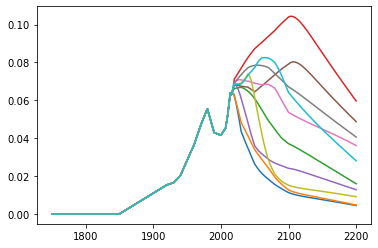

In [24]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_strat = pd.read_csv('../data_input/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat.insert(0, 1750, 0)
skeie_strat_post2010 = skeie_strat.loc['OsloCTM3',[2014,2017,2020]]-skeie_strat.loc['OsloCTM3', 2010]
skeie_strat.loc[:,[2014,2017,2020]] = skeie_strat.loc[:,2010:2010].values + skeie_strat_post2010.values[None,:]
f = interp1d(skeie_strat.columns, skeie_strat.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
o3st = f(years)

for scenario in tqdm_notebook(scenarios):
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    ch4[:265] = ghg_obs['CH4'].values[:265]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    co = new_emissions[scenario]['CO']
    nox = new_emissions[scenario]['NOx']
    voc = new_emissions[scenario]['VOC']
    
    delta_Eco = co[255:265].mean() - co[100:109].mean()
    delta_Enox = nox[255:265].mean() - nox[100:109].mean()
    delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
    delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

    # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
    radeff_ch4 = 0.166/delta_Cch4
    radeff_co  = 0.055/delta_Eco
    radeff_nox = 0.119/delta_Enox
    radeff_voc = 0.035/delta_Evoc

    fac_cmip6_skeie = (
        (
        radeff_ch4 * delta_Cch4 +
        radeff_co  * delta_Eco +
        radeff_nox * delta_Enox +
        radeff_voc * delta_Evoc
        ) / (o3tr[260]-o3tr[100])
    )
    ts = np.vstack((ch4, co, nox, voc)).T

    def fit_stevenson(x, rch4, rco, rnox, rvoc):
        return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

    p, cov = curve_fit(
        fit_stevenson, 
        ts[100:261,:].T - ts[100:261, :].T,
        o3tr[100:261],
        bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
                (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
    )

    forcing[scenario]['o3_stratospheric'] = np.zeros((751))
    forcing[scenario]['o3_stratospheric'][:265] = o3st[:265]
    forcing[scenario]['o3_stratospheric'][265:] = skeie_strat.mean()[2014]/skeie_trop.mean()[2014]*(
        p[0] * (ch4[265:] - ch4[0]) +
        p[1] * (co[265:]  - co[0]) +
        p[2] * (nox[265:]  - nox[0])+
        p[3] * (voc[265:]  - voc[0])
    )# + o3tr[264]

    pl.plot(np.arange(1750,2201), forcing[scenario]['o3_stratospheric'][:451])

## Stratospheric water vapour

In [25]:
forcing_ar6 = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')

for scenario in scenarios:
    forcing[scenario]['h2o_stratospheric'] = forcing[scenario]['ch4']/(forcing_ar6['ch4'].values[269] - forcing_ar6['ch4'].values[0]) * 0.05

In [26]:
colors = {
    'ssp119': '#1e9583',
    'ssp126': '#1d3354',
    'ssp245': '#e9dc3d',  # WHY is ssp245 yellow? This infuriates me
    'ssp370': '#f11111',
    'ssp370-lowNTCF-gidden': '#f11111', 
    'ssp370-lowNTCF-aerchemmip': '#f11111',
    'ssp434': '#63bce4',
    'ssp460': '#e78731',
    'ssp534-over': '#996dc8',
    'ssp585': '#830b22',
}

ls = {
    'ssp119': '-',
    'ssp126': '-',
    'ssp245': '-', 
    'ssp370': '-',
    'ssp370-lowNTCF-gidden': '--', 
    'ssp370-lowNTCF-aerchemmip': '-.',
    'ssp434': '-',
    'ssp460': '-',
    'ssp534-over': '-',
    'ssp585': '-',
}

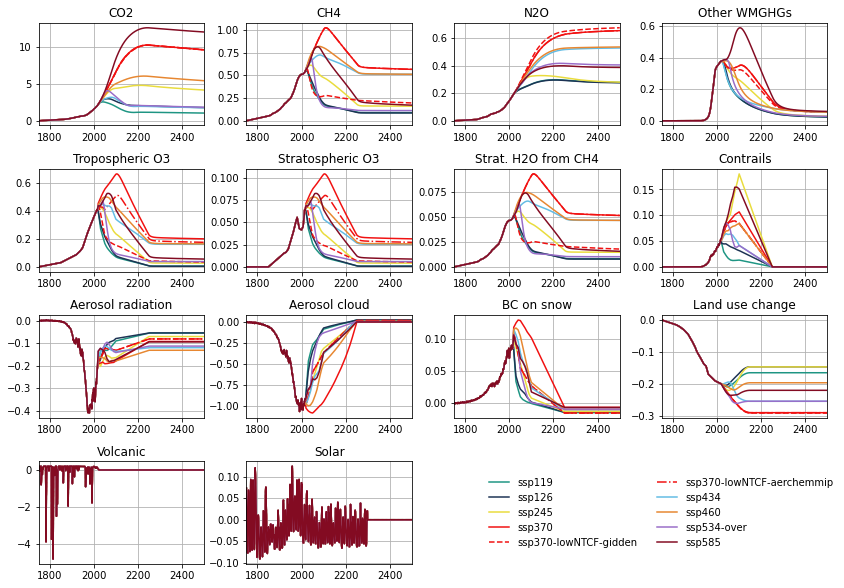

In [27]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(29.7/2.54,21/2.54),squeeze=True)
for scenario in scenarios:
    ax[0,0].plot(np.arange(1750,2501),forcing[scenario]['co2'], color=colors[scenario], ls=ls[scenario])
    ax[0,1].plot(np.arange(1750,2501),forcing[scenario]['ch4'], color=colors[scenario], ls=ls[scenario])
    ax[0,2].plot(np.arange(1750,2501),forcing[scenario]['n2o'], color=colors[scenario], ls=ls[scenario])
    ax[0,3].plot(np.arange(1750,2501),forcing[scenario]['other_wmghg'], color=colors[scenario], ls=ls[scenario])
    ax[1,0].plot(np.arange(1750,2501),forcing[scenario]['o3_tropospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,1].plot(np.arange(1750,2501),forcing[scenario]['o3_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,2].plot(np.arange(1750,2501),forcing[scenario]['h2o_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,3].plot(np.arange(1750,2501),forcing[scenario]['contrails'], color=colors[scenario], ls=ls[scenario])
    ax[2,0].plot(np.arange(1750,2501),forcing[scenario]['aerosol-radiation_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,1].plot(np.arange(1750,2501),forcing[scenario]['aerosol-cloud_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,2].plot(np.arange(1750,2501),forcing[scenario]['bc_on_snow'], color=colors[scenario], ls=ls[scenario])
    ax[2,3].plot(np.arange(1750,2501),forcing[scenario]['land_use'], color=colors[scenario], ls=ls[scenario])
    ax[3,0].plot(np.arange(1750,2501),forcing[scenario]['volcanic'], color=colors[scenario], ls=ls[scenario])
    ax[3,1].plot(np.arange(1750,2501),forcing[scenario]['solar'], color=colors[scenario], ls=ls[scenario], label=scenario)

ax[3,2].axis('off')
ax[3,3].axis('off')
#ax.set_xticks(np.arange(1750,2501,50))
ax[0,0].set_xlim(1750,2500)
ax[0,1].set_xlim(1750,2500)
ax[0,2].set_xlim(1750,2500)
ax[0,3].set_xlim(1750,2500)
ax[1,0].set_xlim(1750,2500)
ax[1,1].set_xlim(1750,2500)
ax[1,2].set_xlim(1750,2500)
ax[1,3].set_xlim(1750,2500)
ax[2,0].set_xlim(1750,2500)
ax[2,1].set_xlim(1750,2500)
ax[2,2].set_xlim(1750,2500)
ax[2,3].set_xlim(1750,2500)
ax[3,0].set_xlim(1750,2500)
ax[3,1].set_xlim(1750,2500)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[0,3].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[1,3].grid()
ax[2,0].grid()
ax[2,1].grid()
ax[2,2].grid()
ax[2,3].grid()
ax[3,0].grid()
ax[3,1].grid()
ax[0,0].set_title('CO2')
ax[0,1].set_title('CH4')
ax[0,2].set_title('N2O')
ax[0,3].set_title('Other WMGHGs')
ax[1,0].set_title('Tropospheric O3')
ax[1,1].set_title('Stratospheric O3')
ax[1,2].set_title('Strat. H2O from CH4')
ax[1,3].set_title('Contrails')
ax[2,0].set_title('Aerosol radiation')
ax[2,1].set_title('Aerosol cloud')
ax[2,2].set_title('BC on snow')
ax[2,3].set_title('Land use change')
ax[3,0].set_title('Volcanic')
ax[3,1].set_title('Solar')
pl.tight_layout()
ax[3,1].legend(bbox_to_anchor=[3.6,0.5], frameon=False, ncol=2, loc='center right')
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/components.png')

In [28]:
for scenario in scenarios:
    forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
        forcing[scenario]['other_wmghg']+\
        forcing[scenario]['o3_tropospheric']+forcing[scenario]['o3_stratospheric']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
        forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
    forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
    forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']

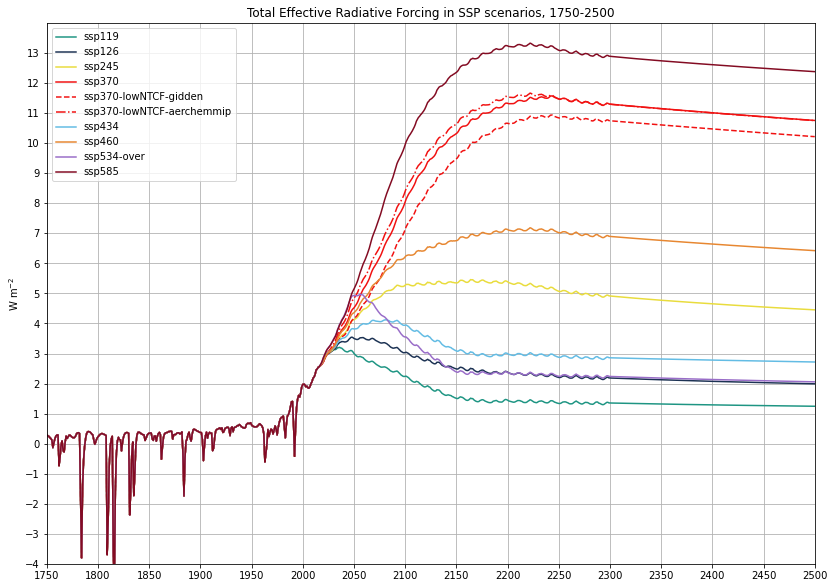

In [29]:
pl.figure(figsize=(29.7/2.54,21/2.54))
for scenario in scenarios:
    pl.plot(np.arange(1750,2501), forcing[scenario]['total'], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.yticks(np.arange(-4,14))
pl.xticks(np.arange(1750,2501,50))
pl.ylim(-4,14)
pl.xlim(1750,2500)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1750-2500')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/total.png')

In [30]:
mkdir_p('../data_output/SSPs/')

for scenario in scenarios:
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
      'volcanic','solar','total_anthropogenic','total_natural','total']]
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('../data_output/SSPs/ERF_%s_1750-2500.csv' % outname)
df

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.206975,0.073621,0.000000,0.280596,0.280596
1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000050,0.0,0.000592,0.002601,-0.000358,-0.000229,0.206987,0.055275,0.005156,0.262262,0.267419
1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000099,0.0,0.001203,0.004054,-0.000483,-0.000458,0.206991,0.025197,0.009417,0.232188,0.241605
1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000149,0.0,0.000562,0.002374,-0.000373,-0.000687,0.206993,-0.010981,0.009526,0.196012,0.205538
1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000198,0.0,-0.000771,-0.001708,0.000023,-0.000916,0.206993,-0.045395,0.006824,0.161598,0.168422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,12.011678,0.171992,0.387326,5.927032e-02,0.056069,0.008816,0.015717,0.0,-0.094427,0.002592,-0.006410,-0.220174,0.000000,0.000000,12.392448,0.000000,12.392448
2497,12.009655,0.171902,0.387320,5.923672e-02,0.056041,0.008812,0.015708,0.0,-0.094427,0.002592,-0.006410,-0.220174,0.000000,0.000000,12.390255,0.000000,12.390255
2498,12.007662,0.171812,0.387311,5.920328e-02,0.056014,0.008808,0.015700,0.0,-0.094427,0.002592,-0.006410,-0.220174,0.000000,0.000000,12.388090,0.000000,12.388090


In [31]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
2000,1.552699,0.512465,0.146780,0.345242,0.357217,0.041550,0.046829,0.038652,-0.302113,-0.916053,0.069653,-0.193651,0.182106,0.086039,1.699269,0.268146,1.967415
2001,1.576555,0.511833,0.149065,0.347165,0.360762,0.042090,0.046771,0.037784,-0.299241,-0.918671,0.070978,-0.193985,0.176846,0.075478,1.731107,0.252324,1.983431
2002,1.606972,0.512160,0.151034,0.348908,0.364307,0.042631,0.046801,0.038350,-0.316375,-0.977186,0.076783,-0.194319,0.183630,0.080766,1.700065,0.264396,1.964461
2003,1.645201,0.513707,0.153176,0.350486,0.367852,0.043171,0.046942,0.038179,-0.332462,-1.000879,0.077903,-0.194654,0.167275,0.019394,1.708623,0.186669,1.895291
2004,1.672599,0.513494,0.155169,0.352206,0.371398,0.043712,0.046923,0.040689,-0.330857,-1.008621,0.080961,-0.194988,0.178190,-0.007392,1.742683,0.170797,1.913481
2005,1.702703,0.512675,0.157336,0.354011,0.374943,0.044252,0.046848,0.042421,-0.342683,-1.033178,0.083727,-0.195322,0.150464,-0.033851,1.747734,0.116613,1.864347
2006,1.734291,0.512722,0.159892,0.355778,0.378488,0.044793,0.046852,0.043095,-0.360329,-1.054382,0.083042,-0.195656,0.135359,-0.039857,1.748587,0.095501,1.844088
2007,1.759977,0.515327,0.162141,0.357848,0.382033,0.045333,0.047090,0.044202,-0.337821,-1.043023,0.086411,-0.195990,0.121751,-0.051371,1.823529,0.070380,1.893909
2008,1.790986,0.517825,0.164860,0.360018,0.385033,0.047567,0.047319,0.044006,-0.322882,-1.014768,0.083685,-0.196324,0.138290,-0.053851,1.907325,0.084439,1.991764


In [32]:
df.loc[2100]

co2                               8.368063
ch4                               0.732891
n2o                               0.347239
other_wmghg                       0.586432
o3_tropospheric                   0.407997
o3_stratospheric                  0.064153
h2o_stratospheric                 0.066971
contrails                         0.150967
aerosol-radiation_interactions   -0.172707
aerosol-cloud_interactions       -0.361889
bc_on_snow                        0.017550
land_use                         -0.230947
volcanic                          0.000000
solar                            -0.024190
total_anthropogenic               9.976720
total_natural                    -0.024190
total                             9.952530
Name: 2100, dtype: float64

In [33]:
df_obs = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv', index_col=0)
df_obs['total'].loc[1980:2026]

year
1980    0.880412
1981    0.923763
1982    0.540456
1983    0.194269
1984    0.633744
1985    0.916836
1986    0.966327
1987    1.067692
1988    1.234774
1989    1.396315
1990    1.404859
1991    0.650723
1992   -0.421479
1993    0.538458
1994    1.206889
1995    1.482893
1996    1.602210
1997    1.542161
1998    1.672769
1999    1.883215
2000    1.965794
2001    1.981806
2002    1.958706
2003    1.891461
2004    1.910869
2005    1.859946
2006    1.843595
2007    1.890413
2008    1.992925
2009    2.061044
2010    2.167867
2011    2.216146
2012    2.286123
2013    2.442279
2014    2.476010
2015    2.521132
2016    2.583155
2017    2.655274
2018    2.685435
2019    2.738876
Name: total, dtype: float64

In [34]:
pl.rcParams['font.size'] = 16

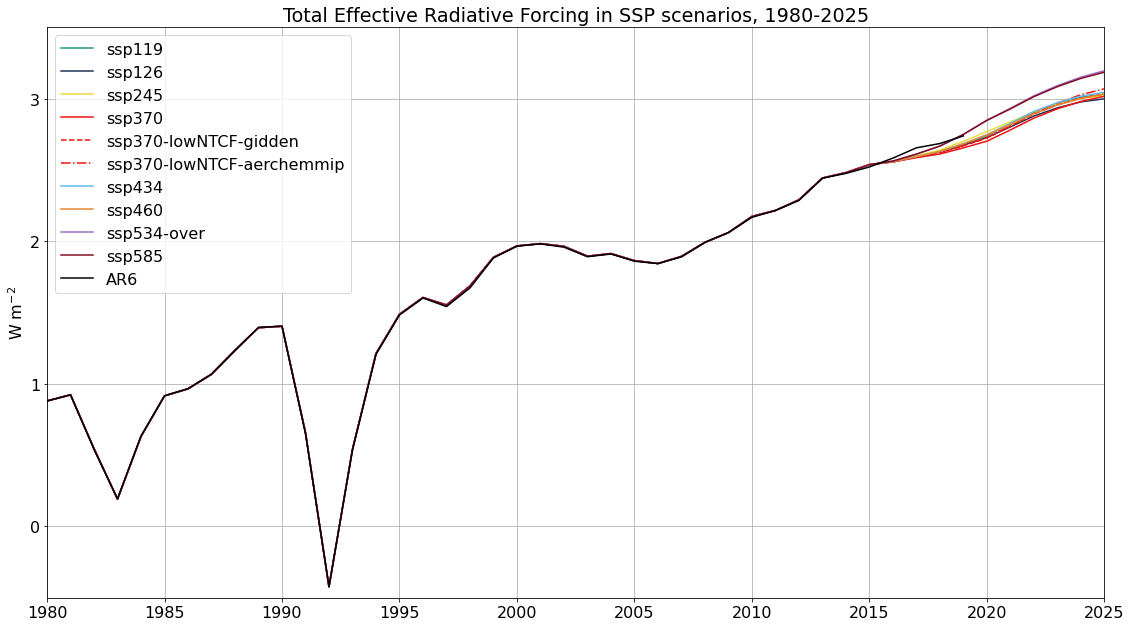

In [35]:
#pl.figure(figsize=(29.7/2.54,21/2.54))
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1980,2026), forcing[scenario]['total'][230:276], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1980,2020), df_obs['total'].loc[1980:2020], color='k', label='AR6')
pl.yticks(np.arange(-4,14))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-0.5,3.5)
pl.xlim(1980,2025)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1980-2025')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

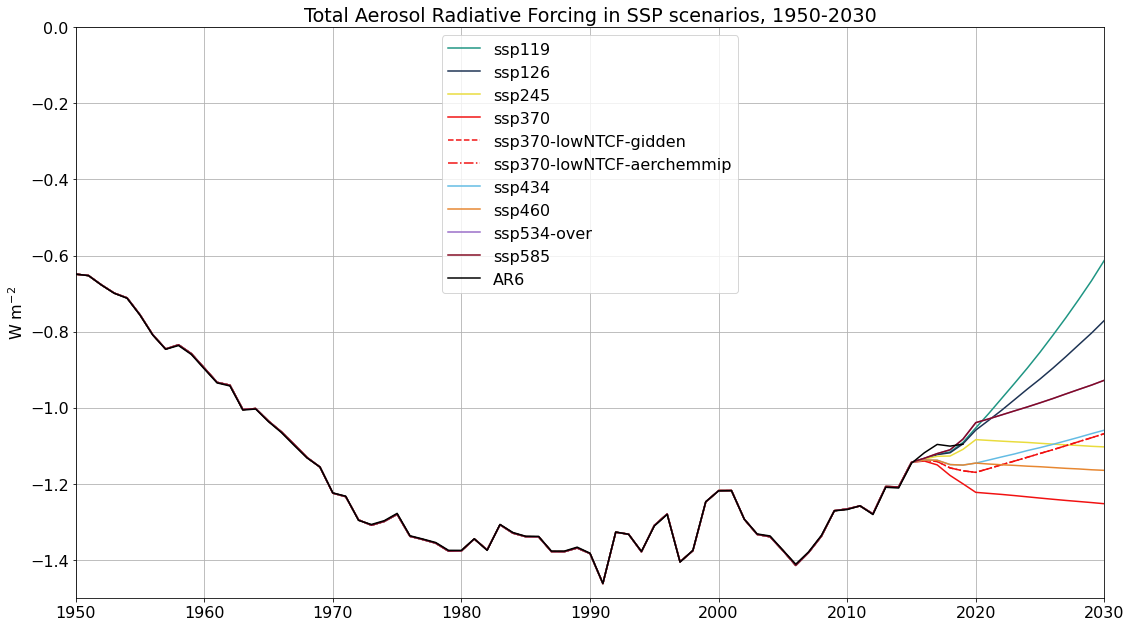

In [36]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1950,2031), forcing[scenario]['aerosol-radiation_interactions'][200:281]+forcing[scenario]['aerosol-cloud_interactions'][200:281], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1950,2020), df_obs['aerosol-radiation_interactions'].loc[1950:2020]+df_obs['aerosol-cloud_interactions'].loc[1950:2020], color='k', label='AR6')
#pl.yticks(np.arange(-1.5,0.25))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-1.5,0)
pl.xlim(1950,2030)
pl.legend()
pl.grid()
pl.title('Total Aerosol Radiative Forcing in SSP scenarios, 1950-2030')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')